Классификация кредитного скоринга



## Загрузка и обзор данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Размер датасета: (96696, 28)
Колонки: ['id', 'customer_id', 'month', 'name', 'age', 'ssn', 'occupation', 'annual_income', 'monthly_inhand_salary', 'credit_history_age', 'total_emi_per_month', 'num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan', 'type_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit', 'num_credit_inquiries', 'credit_mix', 'outstanding_debt', 'credit_utilization_ratio', 'payment_of_min_amount', 'amount_invested_monthly', 'payment_behaviour', 'monthly_balance', 'credit_score']


/tmp/ipython-input-2372913393.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="credit_score", palette="Set2")


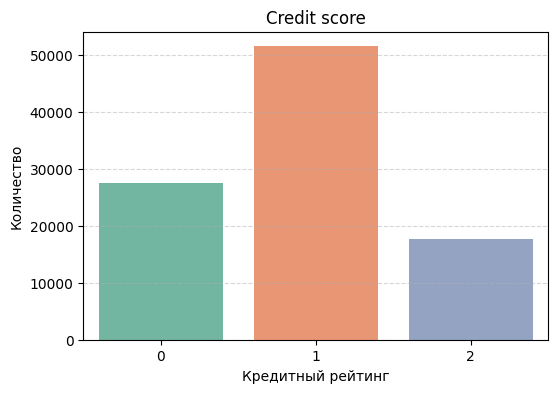

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("drive/MyDrive/credit_score_cleaned_train.csv")
print(f"Размер датасета: {df.shape}")
print("Колонки:", df.columns.tolist())
df.head()
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="credit_score", palette="Set2")
plt.title("Credit score")
plt.xlabel("Кредитный рейтинг")
plt.ylabel("Количество")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Предобработка данных

In [ ]:
df.drop(columns=['id', 'customer_id', 'ssn', 'month', 'name', 'annual_income'], inplace=True)

df = df[df['credit_score'] != 1]

df["target"] = (df["credit_score"] ==2).astype(int)
df.drop(columns=["credit_score"], inplace=True)

from sklearn.preprocessing import LabelEncoder

categorical = df.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("Пропущенные значения:")
print(df.isnull().sum())


Пропущенные значения:
age                         0
occupation                  0
monthly_inhand_salary       0
credit_history_age          0
total_emi_per_month         0
num_bank_accounts           0
num_credit_card             0
interest_rate               0
num_of_loan                 0
type_of_loan                0
delay_from_due_date         0
num_of_delayed_payment      0
changed_credit_limit        0
num_credit_inquiries        0
credit_mix                  0
outstanding_debt            0
credit_utilization_ratio    0
payment_of_min_amount       0
amount_invested_monthly     0
payment_behaviour           0
monthly_balance             0
target                      0
dtype: int64


## Корреляционная матрица

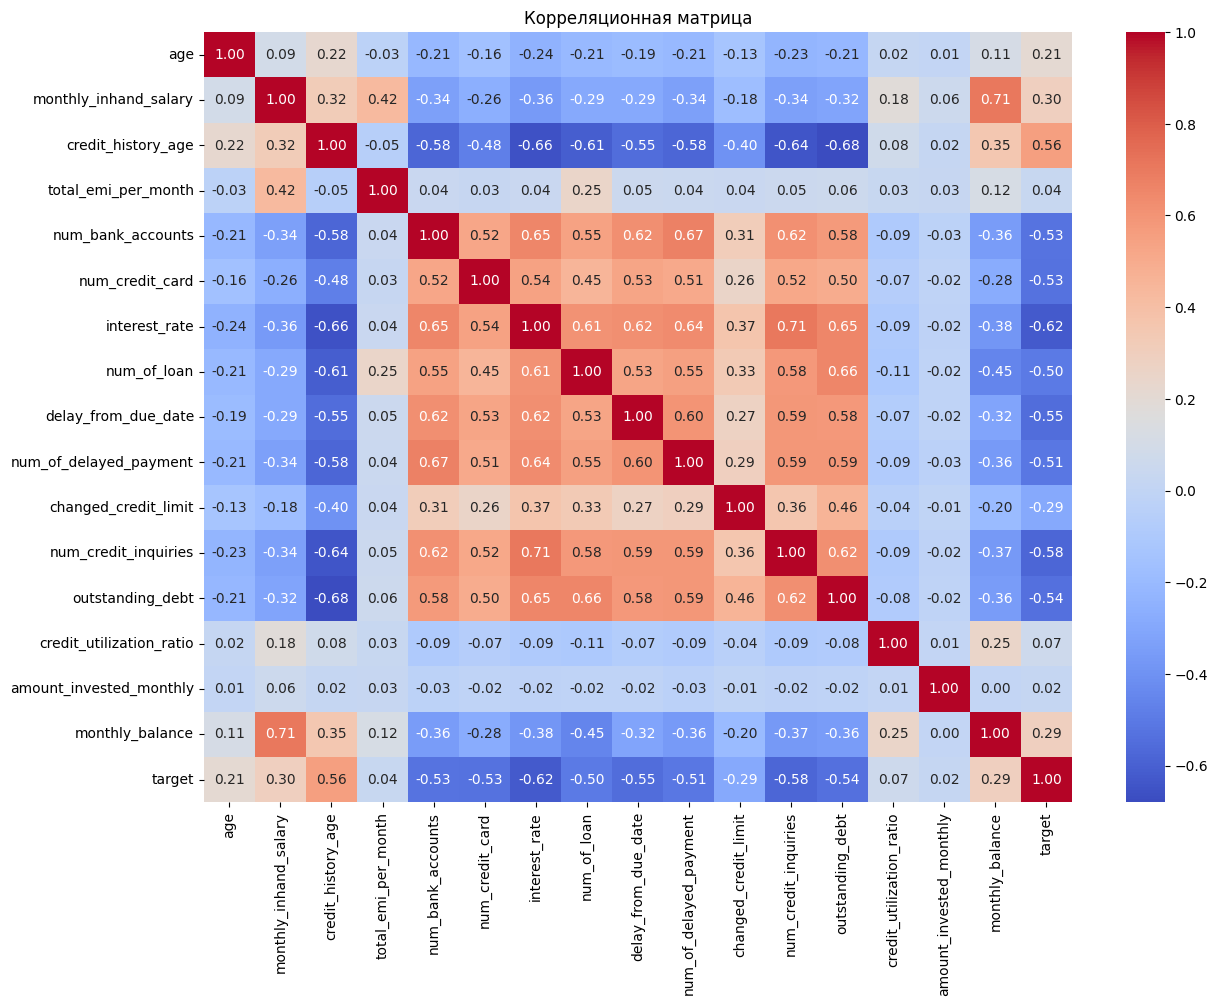

In [ ]:
num_features = [
    'age', 'monthly_inhand_salary', 'credit_history_age',
    'total_emi_per_month', 'num_bank_accounts', 'num_credit_card',
    'interest_rate', 'num_of_loan', 'delay_from_due_date', 'num_of_delayed_payment',
    'changed_credit_limit', 'num_credit_inquiries', 'outstanding_debt',
    'credit_utilization_ratio', 'amount_invested_monthly', 'monthly_balance', 'target'
]
cat_features = ['occupation', 'type_of_loan', 'credit_mix', 'payment_of_min_amount', 'payment_behaviour']
data_encoded = pd.get_dummies(df, columns=cat_features)

plt.figure(figsize=(14, 10))
sns.heatmap(df[num_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()

## Обучение модели логистической регрессии

/tmp/ipython-input-4215192626.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mean(), inplace=True)


              precision    recall  f1-score   support

           0       0.94      0.80      0.87      5497
           1       0.75      0.92      0.83      3542

    accuracy                           0.85      9039
   macro avg       0.84      0.86      0.85      9039
weighted avg       0.87      0.85      0.85      9039



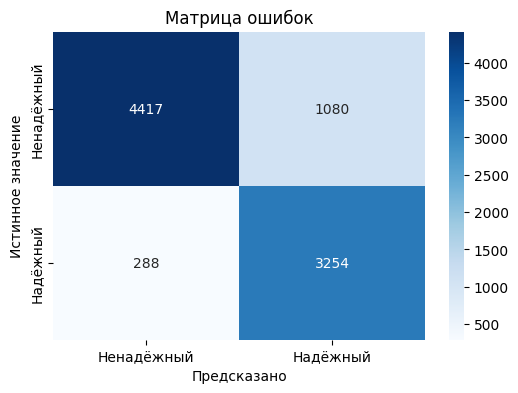

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(columns=["target"])
y = df["target"]

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col].fillna(X[col].mean(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ненадёжный", "Надёжный"], yticklabels=["Ненадёжный", "Надёжный"])
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок")
plt.show()


## Анализ ошибок классификации

In [ ]:
errors = X_test[(y_pred != y_test)]
print(f"Количество ошибок: {len(errors)}")


Количество ошибок: 1368


## Балансировка с помощью SMOTE

              precision    recall  f1-score   support

           0       0.91      0.81      0.85      5497
           1       0.83      0.92      0.87      5497

    accuracy                           0.86     10994
   macro avg       0.87      0.86      0.86     10994
weighted avg       0.87      0.86      0.86     10994



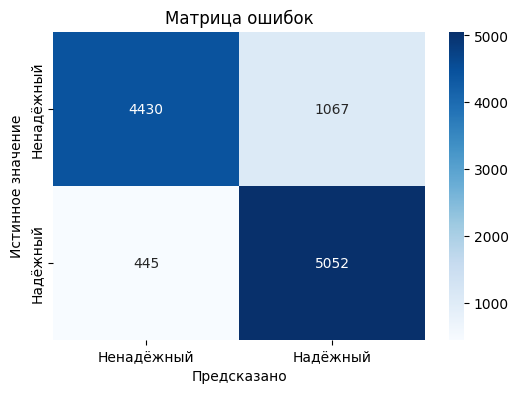

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)


X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_resampled, y_resampled)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ненадёжный", "Надёжный"], yticklabels=["Ненадёжный", "Надёжный"])
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок")
plt.show()

# Нейронная сеть прямого распространения

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [ ]:
model_nn = Sequential([
    Dense(64, input_shape=(X_resampled.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_nn.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history = model_nn.fit(X_resampled, y_resampled,
                       epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8118 - loss: 0.4064 - val_accuracy: 0.9161 - val_loss: 0.3435
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8510 - loss: 0.3326 - val_accuracy: 0.9042 - val_loss: 0.3369
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8595 - loss: 0.3130 - val_accuracy: 0.9000 - val_loss: 0.3335
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8635 - loss: 0.3065 - val_accuracy: 0.9110 - val_loss: 0.3209
Epoch 5/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8628 - loss: 0.3035 - val_accuracy: 0.9098 - val_loss: 0.3269
Epoch 6/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8701 - loss: 0.2960 - val_accuracy: 0.9170 - val_loss: 0.3040
Epoch 7/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8729 - loss: 0.2880 - val_accuracy: 0.9168 - val_loss: 0.3103
Epoch 8/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8758 - loss: 0.2851 - val_accuracy: 0.

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      5497
           1       0.87      0.93      0.90      5497

    accuracy                           0.90     10994
   macro avg       0.90      0.90      0.90     10994
weighted avg       0.90      0.90      0.90     10994



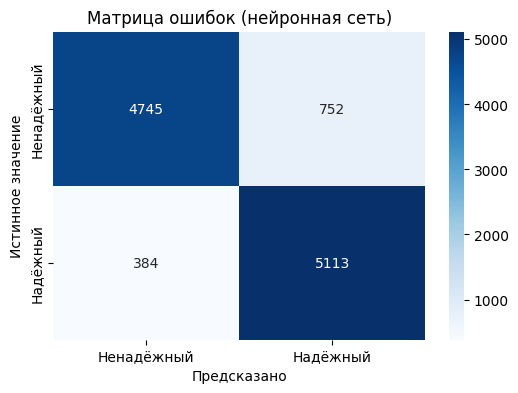

In [ ]:
y_pred_prob = model_nn.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ненадёжный", "Надёжный"], yticklabels=["Ненадёжный", "Надёжный"])
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок (нейронная сеть)")
plt.show()